# Generative Adversarial Networks (GANs) and Adversarial Attacks

## Overview

<font size='4'>In this assignment you will practice putting together implementations of Generative Adversarial Networks (GANs) and adversarial attacks. They will lay solid foundations for you should you be interested in studying advanced topics in these areas.</font>

## Note

<font size='4'>  
- You do not install any additional packages inside the Colab environment. Do not forget to choose to use GPU in the `Runtime\Change runtime type` tab.    
- **You are not allowed to look for answers online. Except for the links provided.
</font>


## Setup

In [ ]:
%matplotlib inline
import argparse
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Set random seed for reproducibility
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Decide which device we want to run on
assert torch.cuda.is_available()
device = 'cuda:0'

Random Seed:  42


## Part 1: Generative Adversarial Networks (GANs, 15 points)

In [ ]:
# Let's download the dataset first
!wget https://jianghz.me/teaching/cs7150/celeba.zip
!unzip celeba.zip

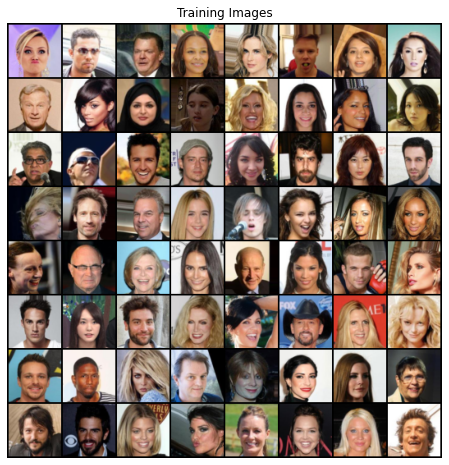

In [ ]:
# Hyper parameters, dataloader, and visualizations of the training data

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# mean and stadard deviation values in the RGB order
# they are used to normalize the input
# What is the range of a pixel value after the normalization?
pix_mean = [0.5, 0.5, 0.5]
pix_std = [0.5, 0.5, 0.5]

dataset = dset.ImageFolder(
    root='celeba',
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(pix_mean, pix_std),
    ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('ConvTranspose2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Conv2d') != -1:
        nn.init.kaiming_normal_(m.weight.data, mode='fan_in', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

### <font color='red'>Task 1.1: Why do we use `nn.Tanh()` as the output of the generator? (2 points)</font>

[Because the output of the generator should be fake data with the same size of the real data and with very similar distribution to the real data's distribution. And because in preprocessing data, the real images and data are normalized somehow that their value could be either negative or posetive, so we need a activation function in the last layer of Generator that outputs negative and posetive value. TanH is a differentiable function which its output changes between -1 and 1 so is very good activation fucntion for the last layer of Genarator]




In [ ]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)

# Print the model
print(netG)

noise = torch.randn(2, nz, 1, 1).to(device)
out = netG(noise)
print(out.shape)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).squeeze()

### <font color='red'>Task 1.2: Why do we use `nn.Sigmoid()` as the output in the discriminator? (2 points)</font>

[Because here the discriminator should do classification. It should try to distinguish real data from the data created by the generator. The output of the discriminator should be compared to zero labels and ones labels. So, in the discriminator, in the last layer we need a activation function which its output should be between 0 as fail and 1 as pass to be able to represent a probability of fail and pass. Sigmoid is a differentiable function which its output change smoothly between 0 and 1 and could represent the probabilty of faill and pass well and also cause a better converging]

In [ ]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
netD.apply(weights_init)

# Print the model
print(netD)

x = torch.rand((2, 3, 64, 64)).to(device)
y = netD(x)
print(y.shape)

In [ ]:
# Initialize BCELoss function
# check the documentation here https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
REAL_LABEL = 1.
FAKE_LABEL = 0.

### <font color='red'>Task 1.3: Finish GANs training and tune the hyper parameters. (11 points, where 3 for hyper parameters, 4 for the generator training, and 4 for the discriminator training.) </font>

<font size='4'>The evaluation of generated images is tricky. It is intentionally to be vague here. The provided hyper parameters should generate roughly OK face images. Use your wisdom to tune them to show better results.</font>

In [ ]:
# Training Loop
# Learning rate for optimizers

###########################################################################
# TODO: Tune the hyper parameters.                                        #
###########################################################################
lr_generator = 0.0002
lr_discriminator = 0.0002

# Beta1 hyperparam for Adam optimizers

beta1 = 0.099
beta2 = 0.999
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

num_epochs = 50

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_discriminator, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr_generator, betas=(beta1, beta2))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

netD.apply(weights_init)
netG.apply(weights_init)


print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        batch_size = data[0].shape[0]   #    128
        real_ims = data[0].to(device)   #    torch.Size([128, 3, 64, 64])
        real_labels = torch.full((batch_size,), REAL_LABEL, dtype=torch.float).to(device)  # torch.Size([128])
        fake_labels = torch.full((batch_size,), FAKE_LABEL, dtype=torch.float).to(device)  # torch.Size([128])
        noise = torch.randn(batch_size, nz, 1, 1).to(device)   #      torch.Size([128, 128, 1, 1])

        fake_ims = None
        #g_loss = None
        g_loss=0
        ###########################################################################
        # TODO: Train the generator. Generate fake images using the noise. Feed   #
        # the fake images into the discrminator as if they were real images.      #
        # The idea is that a good generator should generate good fake images that #
        # can fool the discrminator.                                              #
        # *Update the generator only in this step.*                               #
        ###########################################################################

        optimizerG.zero_grad()

        fake_ims = netG(noise) #  torch.Size([128, 3, 64, 64])
        outD = netD(fake_ims)

        g_loss = criterion(outD,real_labels)

        g_loss.backward()  # compute new gradients

        #torch.nn.utils.clip_grad_norm_(netG.parameters(), 1)
        #torch.autograd.set_detect_anomaly(True)

        optimizerG.step()

        #raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################


        # we suprress gradient backpropagation to the generator
        fake_ims_detached = fake_ims.detach()
        d_loss = None
        d_loss=0
        ###########################################################################
        # TODO: Train the discriminator. Feed real and fake images to the         #
        # discriminator and compute their loss with the corresponding labels. The #
        # idea is that a good discriminator should be smart enought to tell       #
        # what are real and what are fake.                                        #
        # *Update the discriminator only in this step.*                           #
        ###########################################################################

        optimizerD.zero_grad()


        #fake_ims_detached = netG(noise) #  torch.Size([128, 3, 64, 64])
        outD1 = netD(fake_ims_detached)
        d_loss = criterion(outD1, fake_labels)

        outD2 = netD(real_ims)
        d_loss += criterion(outD2, real_labels)
        d_loss /=2
        d_loss.backward()
        #torch.nn.utils.clip_grad_norm_(netD.parameters(), 1)

        optimizerD.step()

        #raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        # Output training stats
        if i % 10 == 0:
            print('[{:d}/{:d}][{:d}/{:d}]\tLoss_Discriminator: {:.4f}\tLoss_Generator: {:.4f}'.format(
                epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item()
            ))

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/16]	Loss_Discriminator: 0.7148	Loss_Generator: 0.8429
[0/50][10/16]	Loss_Discriminator: 0.7939	Loss_Generator: 0.3510
[1/50][0/16]	Loss_Discriminator: 0.5401	Loss_Generator: 0.6069
[1/50][10/16]	Loss_Discriminator: 0.5232	Loss_Generator: 0.6175
[2/50][0/16]	Loss_Discriminator: 0.0774	Loss_Generator: 5.6546
[2/50][10/16]	Loss_Discriminator: 0.2477	Loss_Generator: 15.6606
[3/50][0/16]	Loss_Discriminator: 1.0613	Loss_Generator: 0.2176
[3/50][10/16]	Loss_Discriminator: 0.1846	Loss_Generator: 5.7826
[4/50][0/16]	Loss_Discriminator: 0.1786	Loss_Generator: 13.9777
[4/50][10/16]	Loss_Discriminator: 0.5195	Loss_Generator: 0.6314
[5/50][0/16]	Loss_Discriminator: 0.4410	Loss_Generator: 14.9587
[5/50][10/16]	Loss_Discriminator: 0.9973	Loss_Generator: 23.7829
[6/50][0/16]	Loss_Discriminator: 0.0527	Loss_Generator: 3.6074
[6/50][10/16]	Loss_Discriminator: 1.4017	Loss_Generator: 0.0955
[7/50][0/16]	Loss_Discriminator: 2.3014	Loss_Generator: 22.4364
[7/50][10/16]	Los

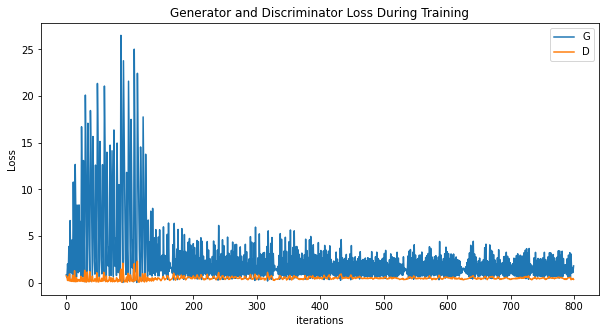

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

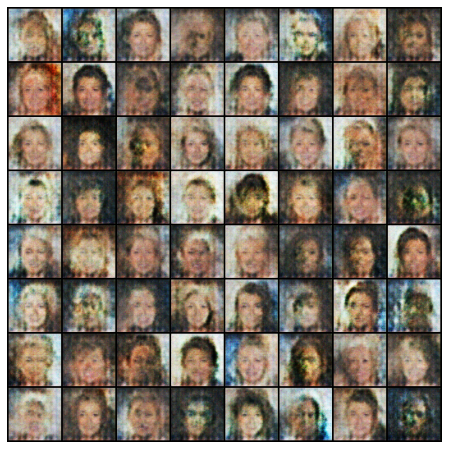

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Part 2: Adversarial Attacks (10 points)

In [ ]:
# Let's first download a pre-trained AlexNet that was pre-trained on ImageNet
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model = model.to(device)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

from PIL import Image
input_image = Image.open(filename)
visualize_image_tensor(input_image)

def visualize_image_tensor(im_tensor):
    # convert a torch.Tensor to a numpy array and visualize it
    assert im_tensor.shape[0] == 1

    im = im_tensor.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    for c in range(3):
        im[:, :, c] = (im[:, :, c] * pix_std[c] + pix_mean[c]) * 255

    plt.imshow(im.astype(np.uint8))
    plt.show()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1546x1213 at 0x7F54017F8850>


--2022-05-08 22:21:03--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.4’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-05-08 22:21:03 (110 MB/s) - ‘imagenet_classes.txt.4’ saved [10472/10472]

Top K predictions (category name, probabily, and the index of the category)
Samoyed,	0.724	258
wallaby,	0.139	104
Pomeranian,	0.059	259
Angora,	0.023	332
Arctic fox,	0.012	279


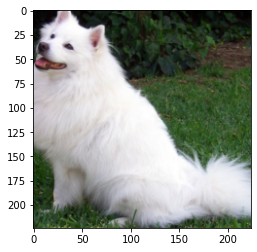

Least possible K predictions (category name, probabily, and the index of the category)
goldfish,	-0.000	1
tench,	-0.000	0
great white shark,	-0.000	2
hammerhead,	-0.000	4
tiger shark,	-0.000	3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Pixel mean and std values in the RGB order for a PyTorch ImageNet pre-trained model
pix_mean = [0.485, 0.456, 0.406]
pix_std = [0.229, 0.224, 0.225]
# Pre-processing of an image
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=pix_mean, std=pix_std),
])

def classify_image(input_tensor, topk=1):
    # Classify an image tensor and output the topk results
    if len(input_tensor.shape) < 4:
        input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    else:
        input_batch = input_tensor

    # move the input and model to GPU for speed if available
    input_batch = input_batch.to(device)

    with torch.no_grad():
        output = model(input_batch)

    # The output has the shape 1000. To get probabilities, you can run a softmax on the unnormalized scores.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # Show top categories per image
    print('Top K predictions (category name, probabily, and the index of the category)')
    topk_prob, topk_catid = torch.topk(probabilities, topk)
    for i in range(topk_prob.size(0)):
        print('{},\t{:.3f}\t{}'.format(
            categories[topk_catid[i]], topk_prob[i].item(), topk_catid[i].item()
        ))
    return topk_catid[0]

input_tensor = preprocess(input_image).unsqueeze(0)
classify_image(input_tensor, 5)
visualize_image_tensor(input_tensor)

with torch.no_grad():
    output = model(input_tensor.to(device)).squeeze()
    output = torch.nn.functional.softmax(output)
topk_prob, topk_catid = torch.topk(-output, 5)
print('Least possible K predictions (category name, probabily, and the index of the category)')
for i in range(topk_prob.size(0)):
    print('{},\t{:.3f}\t{}'.format(
            categories[topk_catid[i]], topk_prob[i].item(), topk_catid[i].item()
    ))

### <font color='red'>Task 2.1: Implement the fast gradient sign method (2 points).</font>

In [ ]:
def adversarial_attack(image, epsilon, data_grad, increase_loss):
    """
    Making adversarial images using the fast gradient sign method, explained in the paper
    https://arxiv.org/pdf/1412.6572.pdf.

    Inputs:
    - image: A torch.Tensor has the shape of BxCxHxW, where B is the batch size, C is the channel dimension,
      H is the height, and W is the width
    - epsilon: A scalar.
    - data_grad: A torch.Tensor has the shape of image, which is the gradient of a loss function w.r.t. the image
    - increase_loss: A boolean variable indicating whether we would like to increase or descrease the value of
      the loss function after manipulating the image.
    """

    perturbed_image = None
    ###########################################################################
    # TODO: Implment the fast gradient sign method. You may find the function #
    # torch.sign https://pytorch.org/docs/stable/generated/torch.sign.html#torch.sign
    # useful.                                                                 #
    ###########################################################################

    sign_grad = torch.sign(data_grad)

    if increase_loss:

      perturbed_image = image + epsilon*sign_grad

    else:
      perturbed_image = image - epsilon*sign_grad


    #raise NotImplementedError
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    # Adding clipping to maintain a valid range for pixel values
    perturbed_image = torch.clamp(perturbed_image, image.min().item(), image.max().item())
    return perturbed_image


### <font color='red'>Task 2.2: Generate an attacked image (3 points).</font>

In [ ]:
def attack_image(model, im_tensor, epsilon, target_label, increase_loss=True):
    """
    Generate an adversarially attacked image given a pre-trained model and a specified target label.

    Inputs:
    - model: A pre-trained model, for example, the AlexNet model.
    - im_tensor: A torch.Tensor has the shape of BxCxHxW, where B is the batch size, C is the channel dimension,
      H is the height, and W is the width
    - epsilon: A scalar.
    - data_grad: A torch.Tensor has the shape of im_tensor, which is the gradient of a loss function w.r.t.
      the image
    - target_label: A non-negative number indicating the index (0-based) of a category.
    - increase_loss: A boolean variable indicating whether we would like to increase or descrease the value of
      the loss function after manipulating the image.
    """

    # Enable gradient computing for the input image
    im_tensor.requires_grad = True

    # Zero all existing gradients
    model.zero_grad()

    # Calculate the loss
    target = torch.Tensor([target_label]).long().to(device)


    # Initial prediction (category label) of the input
    init_pred = None
    # Attacked image tensor
    attacked_tensor = None
    # Prediction (category label) of the attacked image
    attacked_pred = None
    ###########################################################################
    # TODO: Run the forward pass by feeding the image to the model. Then      #
    # calculate the loss according to the target label. Do the backpropagation#
    # to get the gradients, which can be used to get the attacked image.      #
    # Re-classify the perturbed (manipulated) image to check of the attack    #
    # works or not. You can get the gradients of the input image after the    #
    # backpropagation as im_tensor.grad.data.                                 #
    ###########################################################################



    init_label = model(im_tensor)

    probabilities = torch.nn.functional.softmax(init_label)

    _, init_pred = torch.topk(probabilities, 1)
    init_pred = torch.Tensor([init_pred]).long().to(device)

    target_llable =torch.zeros_like(probabilities)
    target_llable [0,target_label] = 1.

    loss = torch.nn.CrossEntropyLoss()

    loss_val = loss(probabilities, target_llable)

    #loss_val.backward()

    loss_val.backward(retain_graph = True)#calculate the gradients of loss with respect to input_image

    attacked_tensor = adversarial_attack(im_tensor, epsilon, im_tensor.grad.data, increase_loss)



    probabilities_att = torch.nn.functional.softmax(init_label)

    _, attacked_pred = torch.topk(probabilities_att, 1)
    attacked_pred = torch.Tensor([attacked_pred]).long().to(device)


    #raise NotImplementedError
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return attacked_tensor, init_pred.item(), attacked_pred.item()

### <font color='red'>Task 2.3: Attack an image so that the initial correct classification is incorrect (2 points).</font>

In [ ]:
# Set requires_grad attribute of tensor. Important for Attack
data = preprocess(input_image).unsqueeze(0)
data = data.to(device)

# 258 is the correct label of the image, which is Samoyed
target = 258
attacked_data, init_pred, attacked_pred = None, None, None
epsilon = 0.0001
attacked_pred = 258
###########################################################################
# TODO: Generate an adversarial image of the given input so that the      #
# attacked image looks almost the same as the input for our naked eyes    #
# but the classification result is different.                             #
###########################################################################

while(attacked_pred == target):

  attacked_data, init_pred, attacked_pred = attack_image(model, data, epsilon, target, increase_loss=True)

  if attacked_pred != target:
    break
print(init_pred)

#raise NotImplementedError
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

print(init_pred, attacked_pred)

visualize_image_tensor(attacked_data)

classify_image(attacked_data)

### <font color='red'>Task 2.4: Attack an image so that the output is the same as the given incorrect target label. Can you achieve the goal or not? Briefly explain your experiences. (3 points)</font>

[Describe your expierences here.]

In [ ]:
# Set requires_grad attribute of tensor. Important for Attack
data = preprocess(input_image).unsqueeze(0)
data = data.to(device)

# 3 is an incorrect label of the image, which is tiger shark
target = 3
attacked_data, init_pred, attacked_pred = None, None, None
epsilon = 0.001
###########################################################################
# TODO: Generate an adversarial image of the given input so that the      #
# attacked image looks almost the same as the input for our naked eyes    #
# but the classification result is incorrect that is the same as the      #
# given target.                                                           #
###########################################################################

while(attacked_pred != target):
  attacked_data, init_pred, attacked_pred = attack_image(model, data, epsilon, target, increase_loss=False)

#raise NotImplementedError
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

print(init_pred, attacked_pred)

visualize_image_tensor(attacked_data)

classify_image(attacked_data)